In [1]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

In [2]:
df = pd.read_csv('MRK.csv')
df = df.drop(['Date'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,momentum,pos,neg,...,PFE,JNJ,BMY,VTRS,AMGN,NYSE,NASDAQ,FT6,FT9,ARIMA
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,30.011450,0.000000,0.000000,...,9.982087,42.442802,14.896735,14.296743,46.293800,6671.140137,2017.979980,50.337802,47.947327,31.011450
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,30.440840,0.000000,0.000000,...,10.023851,42.345844,15.140837,14.335833,46.278458,6697.220215,2024.229980,50.140845,47.659130,31.440840
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,30.183207,0.000000,0.000000,...,10.005951,41.992607,15.114449,14.208794,46.953163,6687.939941,2024.430054,49.944470,47.372320,31.183207
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,30.364504,0.000000,0.000000,...,10.059650,41.895649,15.028677,14.541050,46.194138,6722.310059,2027.729980,49.748691,47.086936,31.364504
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,29.839695,0.000000,0.000000,...,10.029818,41.757114,14.593256,14.462871,45.703426,6709.040039,2028.770020,49.553518,46.803017,30.839695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,77.301529,0.124278,0.019176,...,32.118999,142.130844,56.987370,17.140457,209.706986,12302.190430,9682.910156,55.622779,55.790021,76.887436
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,76.814888,0.491229,0.013877,...,31.985760,140.295029,57.630974,17.296814,209.593124,12286.980470,9615.809570,55.415062,55.480641,78.191500
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,77.492363,0.825178,0.013980,...,31.967995,140.840057,58.047424,17.267496,214.138351,12641.440430,9814.080078,55.207594,55.171523,77.972240
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,78.103050,0.000000,0.000000,...,32.500950,140.333298,58.142071,18.352213,214.214249,12836.599610,9924.750000,55.000389,54.862711,78.309688


In [3]:
target = "Close"
features = list(df.columns.difference(["Close"]))
features

['12ema',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT6',
 'FT9',
 'JNJ',
 'MACD',
 'NASDAQ',
 'NYSE',
 'PFE',
 'SNP',
 'VTRS',
 'Volume',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos']

In [4]:
size = int(len(df) * 0.8)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [5]:
from Factory import SequenceDataset

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 21])
Target shape: torch.Size([1])


In [6]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


In [7]:
from Factory import QShallowRegressionLSTM

learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)
Untrained test
--------
Test loss: 6.61190484798349
Execution time 32.31268811225891
Epoch 0
---------
Train loss: 0.03081605110465908
Test loss: 1.0318539021286648
Execution time 260.188542842865
Epoch 1
---------
Train loss: 0.003178995754571491
Test loss: 0.9173378775603951
Execution time 259.5953769683838
Epoch 2
---------
Train loss: 0.0020263069605116956
Test loss: 0.800125913898458
Execution time 318.43716979026794
Epoch 3
---------
Train loss: 0.0014098669276347258
Test loss: 0.7506935036760936
Execution time 265.0705373287201
Epoch 4
---------
Train loss: 0.001080112257588524
Test loss: 0.7051388708805478
Execution time 263.23922204971313
Epoch 5
---------
Train loss: 0.000905503543275151
Test loss: 0.6810329797930692
Execution time 262.98129200935364
Epoch 6
---------
Train loss: 0.0007681605637338388
Test loss: 0.6816286544310001
Execution time 262.1859300136566
Epoch 7
---------
Train loss: 0.000663155884795258

In [8]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q.head(200))

         Close  Model forecast
0    31.011450       30.759537
1    31.440840       31.072285
2    31.183207       30.956861
3    31.364504       31.054535
4    30.839695       30.696346
..         ...             ...
195  32.719467       32.213036
196  31.650763       31.333534
197  31.784351       31.432503
198  32.261452       31.818363
199  32.166031       31.726364

[200 rows x 2 columns]


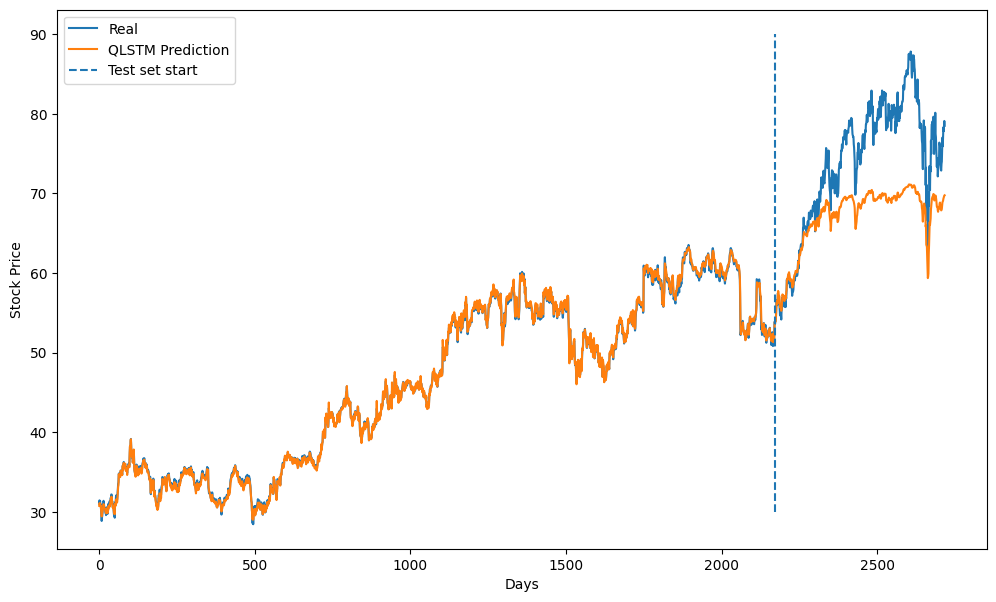

In [9]:
x = np.loadtxt("data.txt")
plt.figure(figsize=(12, 7))
plt.plot(range(2718), df_out_Q["Close"], label = "Real")
plt.plot(range(2718), df_out_Q["Model forecast"], label = "Optimaly QLSTM")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

df_out_Q["Model forecast"]

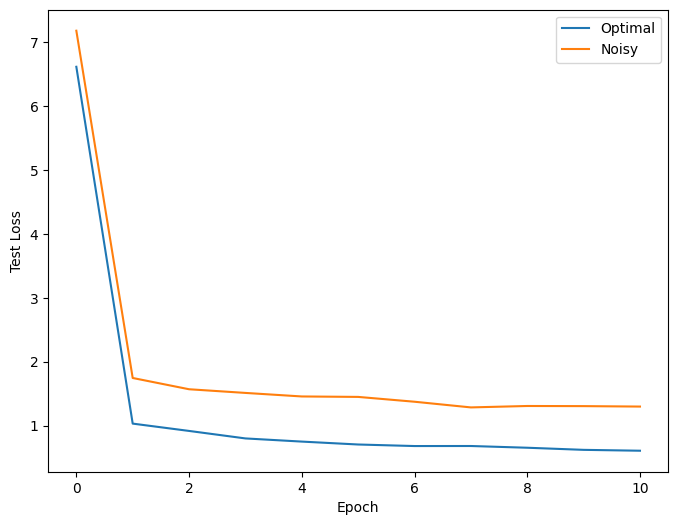

In [15]:
x = [7.1757627142155,
 1.7454564999258722,
 1.5691974108048545,
 1.5117370451740257,
 1.4564584884950478,
 1.4494184223538331,
 1.3739537690216035,
 1.285196575717947,
 1.3073485500586794,
 1.3052887390863632,
 1.2983264739646558]
plt.figure(figsize=(8, 6))
plt.plot(range(11), quantum_loss_test, label = "Optimal")
plt.plot(x, label = "Noisy")
plt.legend()
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

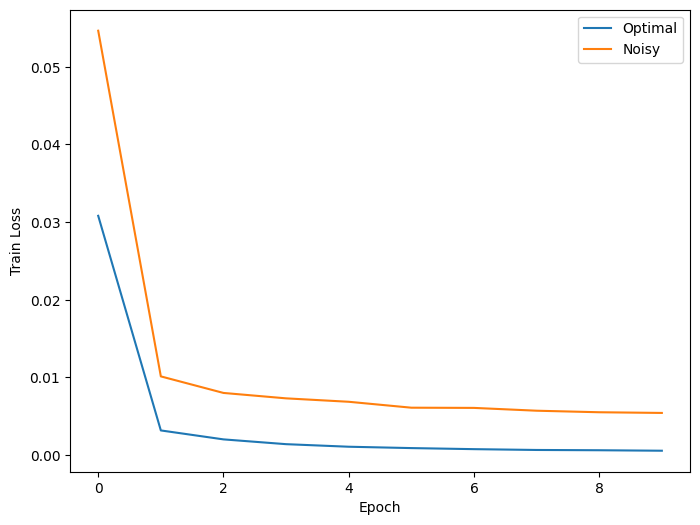

In [18]:
y = [0.054649655644797714, 0.010138496819153334, 0.008006873150059227, 0.007310051934771149, 0.006869264243834431, 0.006106808792841567, 0.006080288356523769, 0.005718029825191313, 0.005520256558715281, 0.005432057320180615]
plt.figure(figsize=(8, 6))
plt.plot(quantum_loss_train, label = "Optimal")
plt.plot(y, label = "Noisy")
plt.ylabel('Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()